In [1]:
#sample code from https://github.com/maurock/snake-ga 

import pygame
import random
from random import randint
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout
from keras import optimizers
from operator import add
import matplotlib.pyplot as plt
import seaborn as sns


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


Using TensorFlow backend.


In [2]:


class DQNAgent(object):

    def __init__(self):
        self.reward = 0
        self.gamma = 0.9
        self.dataframe = pd.DataFrame()
        self.short_memory = np.array([])
        self.agent_target = 1
        self.agent_predict = 0
        self.learning_rate = 0.0005
        self.model = self.network()
        self.epsilon = 0
        self.actual = []
        self.memory = []

    def get_state(self, game, player, food):

        state = [
            (player.x_change == 20 and player.y_change == 0 and ((list(map(add, player.position[-1], [20, 0])) in player.position) or
            player.position[-1][0] + 20 >= (game.game_width - 20))) or (player.x_change == -20 and player.y_change == 0 and ((list(map(add, player.position[-1], [-20, 0])) in player.position) or
            player.position[-1][0] - 20 < 20)) or (player.x_change == 0 and player.y_change == -20 and ((list(map(add, player.position[-1], [0, -20])) in player.position) or
            player.position[-1][-1] - 20 < 20)) or (player.x_change == 0 and player.y_change == 20 and ((list(map(add, player.position[-1], [0, 20])) in player.position) or
            player.position[-1][-1] + 20 >= (game.game_height-20))),  # danger straight

            (player.x_change == 0 and player.y_change == -20 and ((list(map(add,player.position[-1],[20, 0])) in player.position) or
            player.position[ -1][0] + 20 > (game.game_width-20))) or (player.x_change == 0 and player.y_change == 20 and ((list(map(add,player.position[-1],
            [-20,0])) in player.position) or player.position[-1][0] - 20 < 20)) or (player.x_change == -20 and player.y_change == 0 and ((list(map(
            add,player.position[-1],[0,-20])) in player.position) or player.position[-1][-1] - 20 < 20)) or (player.x_change == 20 and player.y_change == 0 and (
            (list(map(add,player.position[-1],[0,20])) in player.position) or player.position[-1][
             -1] + 20 >= (game.game_height-20))),  # danger right

             (player.x_change == 0 and player.y_change == 20 and ((list(map(add,player.position[-1],[20,0])) in player.position) or
             player.position[-1][0] + 20 > (game.game_width-20))) or (player.x_change == 0 and player.y_change == -20 and ((list(map(
             add, player.position[-1],[-20,0])) in player.position) or player.position[-1][0] - 20 < 20)) or (player.x_change == 20 and player.y_change == 0 and (
            (list(map(add,player.position[-1],[0,-20])) in player.position) or player.position[-1][-1] - 20 < 20)) or (
            player.x_change == -20 and player.y_change == 0 and ((list(map(add,player.position[-1],[0,20])) in player.position) or
            player.position[-1][-1] + 20 >= (game.game_height-20))), #danger left


            player.x_change == -20,  # move left
            player.x_change == 20,  # move right
            player.y_change == -20,  # move up
            player.y_change == 20,  # move down
            food.x_food < player.x,  # food left
            food.x_food > player.x,  # food right
            food.y_food < player.y,  # food up
            food.y_food > player.y  # food down
            ]

        for i in range(len(state)):
            if state[i]:
                state[i]=1
            else:
                state[i]=0

        return np.asarray(state)

    def set_reward(self, player, crash):
        self.reward = 0
        if crash:
            self.reward = -10
            return self.reward
        if player.eaten:
            self.reward = 10
        return self.reward

    def network(self, weights=None):
        model = Sequential()
        model.add(Dense(activation="relu", input_dim=11, units=120))
        model.add(Dense(activation="relu", units=120))
        model.add(Dense(activation="relu", units=120))
        model.add(Dense(activation="softmax", units=3))
        adam = optimizers.Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        model.compile(loss='mse', optimizer= adam)
        
        if weights:
            model.load_weights(weights)
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay_new(self, memory):
        if len(memory) > 1000:
            minibatch = random.sample(memory, 1000)
        else:
            minibatch = memory
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(np.array([next_state]))[0])
            target_f = self.model.predict(np.array([state]))
            target_f[0][np.argmax(action)] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)

    def train_short_memory(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape((1, 11)))[0])
        target_f = self.model.predict(state.reshape((1, 11)))
        target_f[0][np.argmax(action)] = target
        self.model.fit(state.reshape((1, 11)), target_f, epochs=1, verbose=0)

In [3]:
# Set options to activate or deactivate the game view, and its speed
#to view game while running set *display_option* = True and *speed* = 50
#to NOT view game while running set *display_option* = False and *speed* = 0
display_option = True
speed = 50
pygame.font.init()

In [4]:
class Game:

    def __init__(self, game_width, game_height):
        pygame.display.set_caption('Hungry Snake')
        self.game_width = game_width
        self.game_height = game_height
        self.gameDisplay = pygame.display.set_mode((game_width, game_height+60))
        self.bg = pygame.image.load("img/background.png")
        self.crash = False
        self.player = Player(self)
        self.food = Food()
        self.score = 0

In [5]:
class Player(object):

    def __init__(self, game):
        x = 0.45 * game.game_width
        y = 0.5 * game.game_height
        self.x = x - x % 20
        self.y = y - y % 20
        self.position = []
        self.position.append([self.x, self.y])
        self.food = 1
        self.eaten = False
        self.image = pygame.image.load('img/snakeBody.png')
        self.x_change = 20
        self.y_change = 0

    def update_position(self, x, y):
        if self.position[-1][0] != x or self.position[-1][1] != y:
            if self.food > 1:
                for i in range(0, self.food - 1):
                    self.position[i][0], self.position[i][1] = self.position[i + 1]
            self.position[-1][0] = x
            self.position[-1][1] = y

    def do_move(self, move, x, y, game, food,agent):
        move_array = [self.x_change, self.y_change]

        if self.eaten:

            self.position.append([self.x, self.y])
            self.eaten = False
            self.food = self.food + 1
        if np.array_equal(move ,[1, 0, 0]):
            move_array = self.x_change, self.y_change
        elif np.array_equal(move,[0, 1, 0]) and self.y_change == 0:  # right - going horizontal
            move_array = [0, self.x_change]
        elif np.array_equal(move,[0, 1, 0]) and self.x_change == 0:  # right - going vertical
            move_array = [-self.y_change, 0]
        elif np.array_equal(move, [0, 0, 1]) and self.y_change == 0:  # left - going horizontal
            move_array = [0, -self.x_change]
        elif np.array_equal(move,[0, 0, 1]) and self.x_change == 0:  # left - going vertical
            move_array = [self.y_change, 0]
        self.x_change, self.y_change = move_array
        self.x = x + self.x_change
        self.y = y + self.y_change

        if self.x < 20 or self.x > game.game_width-40 or self.y < 20 or self.y > game.game_height-40 or [self.x, self.y] in self.position:
            game.crash = True
        eat(self, food, game)

        self.update_position(self.x, self.y)

    def display_player(self, x, y, food, game):
        self.position[-1][0] = x
        self.position[-1][1] = y

        if game.crash == False:
            for i in range(food):
                x_temp, y_temp = self.position[len(self.position) - 1 - i]
                game.gameDisplay.blit(self.image, (x_temp, y_temp))

            update_screen()
        else:
            pygame.time.wait(300)


In [6]:

class Food(object):

    def __init__(self):
        self.x_food = 240
        self.y_food = 200
        self.image = pygame.image.load('img/food2.png')

    def food_coord(self, game, player):
        x_rand = randint(20, game.game_width - 40)
        self.x_food = x_rand - x_rand % 20
        y_rand = randint(20, game.game_height - 40)
        self.y_food = y_rand - y_rand % 20
        if [self.x_food, self.y_food] not in player.position:
            return self.x_food, self.y_food
        else:
            self.food_coord(game,player)

    def display_food(self, x, y, game):
        game.gameDisplay.blit(self.image, (x, y))
        update_screen()


In [7]:
def eat(player, food, game):
    if player.x == food.x_food and player.y == food.y_food:
        food.food_coord(game, player)
        player.eaten = True
        game.score = game.score + 1


In [8]:
def get_record(score, record):
        if score >= record:
            return score
        else:
            return record

In [9]:
def display_ui(game, score, record):
    myfont = pygame.font.SysFont('Segoe UI', 20)
    myfont_bold = pygame.font.SysFont('Segoe UI', 20, True)
    text_score = myfont.render('SCORE: ', True, (0, 0, 0))
    text_score_number = myfont.render(str(score), True, (0, 0, 0))
    text_highest = myfont.render('HIGHEST SCORE: ', True, (0, 0, 0))
    text_highest_number = myfont_bold.render(str(record), True, (0, 0, 0))
    game.gameDisplay.blit(text_score, (45, 440))
    game.gameDisplay.blit(text_score_number, (120, 440))
    game.gameDisplay.blit(text_highest, (190, 440))
    game.gameDisplay.blit(text_highest_number, (350, 440))
    game.gameDisplay.blit(game.bg, (10, 10))

In [10]:
def display(player, food, game, record):
    game.gameDisplay.fill((255, 255, 255))
    display_ui(game, game.score, record)
    player.display_player(player.position[-1][0], player.position[-1][1], player.food, game)
    food.display_food(food.x_food, food.y_food, game)



In [11]:
def update_screen():
    pygame.display.update()

In [12]:
def initialize_game(player, game, food, agent):
    state_init1 = agent.get_state(game, player, food)  # [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
    action = [1, 0, 0]
    player.do_move(action, player.x, player.y, game, food, agent)
    state_init2 = agent.get_state(game, player, food)
    reward1 = agent.set_reward(player, game.crash)
    agent.remember(state_init1, action, reward1, state_init2, game.crash)
    agent.replay_new(agent.memory)


In [13]:
def plot_seaborn(array_counter, array_score):
    sns.set(color_codes=True)
    ax = sns.regplot(np.array([array_counter])[0], np.array([array_score])[0], color="b", x_jitter=.1, line_kws={'color':'green'})
    ax.set(xlabel='Games', ylabel='Score')
    plt.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Game 1       Score: 0
Game 2       Score: 1
Game 3       Score: 0
Game 4       Score: 1
Game 5       Score: 0
Game 6       Score: 1
Game 7       Score: 0
Game 8       Score: 0
Game 9       Score: 1
Game 10       Score: 1
Game 11       Score: 1
Game 12       Score: 0
Game 13       Score: 1
Game 14       Score: 1
Game 15       Score: 1
Game 16       Score: 0
Game 17       Score: 2
Game 18       Score: 2
Game 19       Score: 1
Game 20       Score: 1
Game 21       Score: 2
Game 22       Score: 2
Game 23       Score: 1
Game 24       Score: 1
Game 25       Score: 0
Game 26       Score: 1
Game 27       Score: 1
Game 28       Score: 1
Game 29       Score: 2
Game 30       Score: 3
Game 31       Score: 1
Game 32       Score: 2
Game 33       Score: 1
Game 34       Score: 2
Game 35       Score: 2
Game 36       Score: 2
Game 37       Score: 2
Game 38       Score: 2
Game 39       S

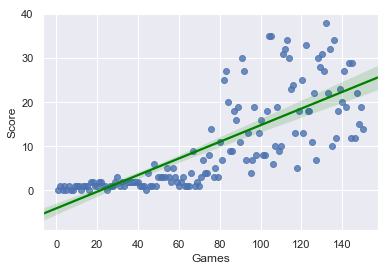

In [ ]:

def run():
    pygame.init()
    agent = DQNAgent()
    counter_games = 0
    score_plot = []
    counter_plot =[]
    record = 0
    while counter_games < 150: 
        # Initialize classes
        game = Game(440, 440)
        player1 = game.player
        food1 = game.food

        # Perform first move
        initialize_game(player1, game, food1, agent)
        if display_option:
            display(player1, food1, game, record)

        while not game.crash:
            #agent.epsilon is set to give randomness to actions
            agent.epsilon = 80 - counter_games
            
            #get old state
            state_old = agent.get_state(game, player1, food1)
            
            #perform random actions based on agent.epsilon, or choose the action
            if randint(0, 200) < agent.epsilon:
                final_move = to_categorical(randint(0, 2), num_classes=3)
            else:
                # predict action based on the old state
                prediction = agent.model.predict(state_old.reshape((1,11)))
                final_move = to_categorical(np.argmax(prediction[0]), num_classes=3)
                
            #perform new move and get new state
            player1.do_move(final_move, player1.x, player1.y, game, food1, agent)
            state_new = agent.get_state(game, player1, food1)
            
            #set reward for the new state
            reward = agent.set_reward(player1, game.crash)
            
            #train short memory base on the new action and state
            agent.train_short_memory(state_old, final_move, reward, state_new, game.crash)
            
            # store the new data into a long term memory
            agent.remember(state_old, final_move, reward, state_new, game.crash)
            record = get_record(game.score, record)
            if display_option:
                display(player1, food1, game, record)
                pygame.time.wait(speed)
        
        agent.replay_new(agent.memory)
        counter_games += 1
        print('Game', counter_games, '      Score:', game.score)
        score_plot.append(game.score)
        counter_plot.append(counter_games)
    agent.model.save_weights('weight_3layers_nodropout.hdf5')
    plot_seaborn(counter_plot, score_plot)


run()


2 layers / learning rate = .0005

In [ ]:


class DQNAgent(object):

    def __init__(self):
        self.reward = 0
        self.gamma = 0.9
        self.dataframe = pd.DataFrame()
        self.short_memory = np.array([])
        self.agent_target = 1
        self.agent_predict = 0
        self.learning_rate = 0.0005
        self.model = self.network()
        self.epsilon = 0
        self.actual = []
        self.memory = []

    def get_state(self, game, player, food):

        state = [
            (player.x_change == 20 and player.y_change == 0 and ((list(map(add, player.position[-1], [20, 0])) in player.position) or
            player.position[-1][0] + 20 >= (game.game_width - 20))) or (player.x_change == -20 and player.y_change == 0 and ((list(map(add, player.position[-1], [-20, 0])) in player.position) or
            player.position[-1][0] - 20 < 20)) or (player.x_change == 0 and player.y_change == -20 and ((list(map(add, player.position[-1], [0, -20])) in player.position) or
            player.position[-1][-1] - 20 < 20)) or (player.x_change == 0 and player.y_change == 20 and ((list(map(add, player.position[-1], [0, 20])) in player.position) or
            player.position[-1][-1] + 20 >= (game.game_height-20))),  # danger straight

            (player.x_change == 0 and player.y_change == -20 and ((list(map(add,player.position[-1],[20, 0])) in player.position) or
            player.position[ -1][0] + 20 > (game.game_width-20))) or (player.x_change == 0 and player.y_change == 20 and ((list(map(add,player.position[-1],
            [-20,0])) in player.position) or player.position[-1][0] - 20 < 20)) or (player.x_change == -20 and player.y_change == 0 and ((list(map(
            add,player.position[-1],[0,-20])) in player.position) or player.position[-1][-1] - 20 < 20)) or (player.x_change == 20 and player.y_change == 0 and (
            (list(map(add,player.position[-1],[0,20])) in player.position) or player.position[-1][
             -1] + 20 >= (game.game_height-20))),  # danger right

             (player.x_change == 0 and player.y_change == 20 and ((list(map(add,player.position[-1],[20,0])) in player.position) or
             player.position[-1][0] + 20 > (game.game_width-20))) or (player.x_change == 0 and player.y_change == -20 and ((list(map(
             add, player.position[-1],[-20,0])) in player.position) or player.position[-1][0] - 20 < 20)) or (player.x_change == 20 and player.y_change == 0 and (
            (list(map(add,player.position[-1],[0,-20])) in player.position) or player.position[-1][-1] - 20 < 20)) or (
            player.x_change == -20 and player.y_change == 0 and ((list(map(add,player.position[-1],[0,20])) in player.position) or
            player.position[-1][-1] + 20 >= (game.game_height-20))), #danger left


            player.x_change == -20,  # move left
            player.x_change == 20,  # move right
            player.y_change == -20,  # move up
            player.y_change == 20,  # move down
            food.x_food < player.x,  # food left
            food.x_food > player.x,  # food right
            food.y_food < player.y,  # food up
            food.y_food > player.y  # food down
            ]

        for i in range(len(state)):
            if state[i]:
                state[i]=1
            else:
                state[i]=0

        return np.asarray(state)

    def set_reward(self, player, crash):
        self.reward = 0
        if crash:
            self.reward = -10
            return self.reward
        if player.eaten:
            self.reward = 10
        return self.reward

    def network(self, weights=None):
        model = Sequential()
        model.add(Dense(activation="relu", input_dim=11, units=120))
        model.add(Dropout(0.15))
        model.add(Dense(activation="relu", units=120))
        model.add(Dropout(0.15))
        model.add(Dense(activation="softmax", units=3))
        adam = optimizers.Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        model.compile(loss='mse', optimizer= adam)
        
        if weights:
            model.load_weights(weights)
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay_new(self, memory):
        if len(memory) > 1000:
            minibatch = random.sample(memory, 1000)
        else:
            minibatch = memory
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(np.array([next_state]))[0])
            target_f = self.model.predict(np.array([state]))
            target_f[0][np.argmax(action)] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)

    def train_short_memory(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape((1, 11)))[0])
        target_f = self.model.predict(state.reshape((1, 11)))
        target_f[0][np.argmax(action)] = target
        self.model.fit(state.reshape((1, 11)), target_f, epochs=1, verbose=0)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Game 1       Score: 0
Game 2       Score: 0
Game 3       Score: 1
Game 4       Score: 2
Game 5       Score: 2
Game 6       Score: 1
Game 7       Score: 0
Game 8       Score: 1
Game 9       Score: 1
Game 10       Score: 1
Game 11       Score: 2
Game 12       Score: 1
Game 13       Score: 1
Game 14       Score: 0
Game 15       Score: 2
Game 16       Score: 2
Game 17       Score: 0
Game 18       Score: 2
Game 19       Score: 1
Game 20       Score: 1
Game 21       Score: 1
Game 22       Score: 4
Game 23       Score: 3
Game 24       Score: 0
Game 25       Score: 3
Game 26       Score: 1
Game 27       Score: 1
Game 28       Score: 11
Game 29       Score: 3
Game 30       Score: 2
Game 31       Score: 3
Game 32       Score: 7
Game 33       Score: 5
Game 34       Score: 2
Game 35       Score: 2
Game 36       Score: 5
Game 37       Score: 2
Game 38       Score: 5
Game 39       Score

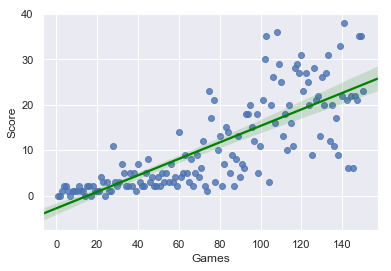

In [ ]:

def run():
    pygame.init()
    agent = DQNAgent()
    counter_games = 0
    score_plot = []
    counter_plot =[]
    record = 0
    while counter_games < 150: 
        # Initialize classes
        game = Game(440, 440)
        player1 = game.player
        food1 = game.food

        # Perform first move
        initialize_game(player1, game, food1, agent)
        if display_option:
            display(player1, food1, game, record)

        while not game.crash:
            #agent.epsilon is set to give randomness to actions
            agent.epsilon = 80 - counter_games
            
            #get old state
            state_old = agent.get_state(game, player1, food1)
            
            #perform random actions based on agent.epsilon, or choose the action
            if randint(0, 200) < agent.epsilon:
                final_move = to_categorical(randint(0, 2), num_classes=3)
            else:
                # predict action based on the old state
                prediction = agent.model.predict(state_old.reshape((1,11)))
                final_move = to_categorical(np.argmax(prediction[0]), num_classes=3)
                
            #perform new move and get new state
            player1.do_move(final_move, player1.x, player1.y, game, food1, agent)
            state_new = agent.get_state(game, player1, food1)
            
            #set reward for the new state
            reward = agent.set_reward(player1, game.crash)
            
            #train short memory base on the new action and state
            agent.train_short_memory(state_old, final_move, reward, state_new, game.crash)
            
            # store the new data into a long term memory
            agent.remember(state_old, final_move, reward, state_new, game.crash)
            record = get_record(game.score, record)
            if display_option:
                display(player1, food1, game, record)
                pygame.time.wait(speed)
        
        agent.replay_new(agent.memory)
        counter_games += 1
        print('Game', counter_games, '      Score:', game.score)
        score_plot.append(game.score)
        counter_plot.append(counter_games)
    agent.model.save_weights('weights_2_layers_0005lr.hdf5')
    plot_seaborn(counter_plot, score_plot)


run()


2 layers / learning rate = .00005

In [22]:


class DQNAgent(object):

    def __init__(self):
        self.reward = 0
        self.gamma = 0.9
        self.dataframe = pd.DataFrame()
        self.short_memory = np.array([])
        self.agent_target = 1
        self.agent_predict = 0
        self.learning_rate = 0.00005  
        self.model = self.network()
        self.epsilon = 0
        self.actual = []
        self.memory = []

    def get_state(self, game, player, food):

        state = [
            (player.x_change == 20 and player.y_change == 0 and ((list(map(add, player.position[-1], [20, 0])) in player.position) or
            player.position[-1][0] + 20 >= (game.game_width - 20))) or (player.x_change == -20 and player.y_change == 0 and ((list(map(add, player.position[-1], [-20, 0])) in player.position) or
            player.position[-1][0] - 20 < 20)) or (player.x_change == 0 and player.y_change == -20 and ((list(map(add, player.position[-1], [0, -20])) in player.position) or
            player.position[-1][-1] - 20 < 20)) or (player.x_change == 0 and player.y_change == 20 and ((list(map(add, player.position[-1], [0, 20])) in player.position) or
            player.position[-1][-1] + 20 >= (game.game_height-20))),  # danger straight

            (player.x_change == 0 and player.y_change == -20 and ((list(map(add,player.position[-1],[20, 0])) in player.position) or
            player.position[ -1][0] + 20 > (game.game_width-20))) or (player.x_change == 0 and player.y_change == 20 and ((list(map(add,player.position[-1],
            [-20,0])) in player.position) or player.position[-1][0] - 20 < 20)) or (player.x_change == -20 and player.y_change == 0 and ((list(map(
            add,player.position[-1],[0,-20])) in player.position) or player.position[-1][-1] - 20 < 20)) or (player.x_change == 20 and player.y_change == 0 and (
            (list(map(add,player.position[-1],[0,20])) in player.position) or player.position[-1][
             -1] + 20 >= (game.game_height-20))),  # danger right

             (player.x_change == 0 and player.y_change == 20 and ((list(map(add,player.position[-1],[20,0])) in player.position) or
             player.position[-1][0] + 20 > (game.game_width-20))) or (player.x_change == 0 and player.y_change == -20 and ((list(map(
             add, player.position[-1],[-20,0])) in player.position) or player.position[-1][0] - 20 < 20)) or (player.x_change == 20 and player.y_change == 0 and (
            (list(map(add,player.position[-1],[0,-20])) in player.position) or player.position[-1][-1] - 20 < 20)) or (
            player.x_change == -20 and player.y_change == 0 and ((list(map(add,player.position[-1],[0,20])) in player.position) or
            player.position[-1][-1] + 20 >= (game.game_height-20))), #danger left


            player.x_change == -20,  # move left
            player.x_change == 20,  # move right
            player.y_change == -20,  # move up
            player.y_change == 20,  # move down
            food.x_food < player.x,  # food left
            food.x_food > player.x,  # food right
            food.y_food < player.y,  # food up
            food.y_food > player.y  # food down
            ]

        for i in range(len(state)):
            if state[i]:
                state[i]=1
            else:
                state[i]=0

        return np.asarray(state)

    def set_reward(self, player, crash):
        self.reward = 0
        if crash:
            self.reward = -10
            return self.reward
        if player.eaten:
            self.reward = 10
        return self.reward

    def network(self, weights=None):
        model = Sequential()
        model.add(Dense(activation="relu", input_dim=11, units=120))
        model.add(Dropout(0.15))
        model.add(Dense(activation="relu", units=120))
        model.add(Dropout(0.15))
        model.add(Dense(activation="softmax", units=3))
        adam = optimizers.Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        model.compile(loss='mse', optimizer= adam)
        
        if weights:
            model.load_weights(weights)
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay_new(self, memory):
        if len(memory) > 1000:
            minibatch = random.sample(memory, 1000)
        else:
            minibatch = memory
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(np.array([next_state]))[0])
            target_f = self.model.predict(np.array([state]))
            target_f[0][np.argmax(action)] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)

    def train_short_memory(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape((1, 11)))[0])
        target_f = self.model.predict(state.reshape((1, 11)))
        target_f[0][np.argmax(action)] = target
        self.model.fit(state.reshape((1, 11)), target_f, epochs=1, verbose=0)

Game 1       Score: 1
Game 2       Score: 1
Game 3       Score: 1
Game 4       Score: 2
Game 5       Score: 1
Game 6       Score: 1
Game 7       Score: 2
Game 8       Score: 1
Game 9       Score: 2
Game 10       Score: 1
Game 11       Score: 1
Game 12       Score: 0
Game 13       Score: 3
Game 14       Score: 1
Game 15       Score: 1
Game 16       Score: 4
Game 17       Score: 1
Game 18       Score: 2
Game 19       Score: 1
Game 20       Score: 1
Game 21       Score: 1
Game 22       Score: 2
Game 23       Score: 4
Game 24       Score: 2
Game 25       Score: 1
Game 26       Score: 2
Game 27       Score: 2
Game 28       Score: 2
Game 29       Score: 3
Game 30       Score: 1
Game 31       Score: 2
Game 32       Score: 0
Game 33       Score: 2
Game 34       Score: 1
Game 35       Score: 1
Game 36       Score: 2
Game 37       Score: 2
Game 38       Score: 1
Game 39       Score: 1
Game 40       Score: 3
Game 41       Score: 2
Game 42       Score: 3
Game 43       Score: 2
Game 44       Score:

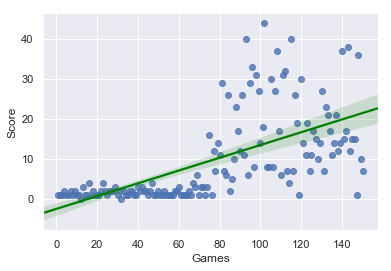

In [23]:

def run():
    pygame.init()
    agent = DQNAgent()
    counter_games = 0
    score_plot = []
    counter_plot =[]
    record = 0
    while counter_games < 150: 
        # Initialize classes
        game = Game(440, 440)
        player1 = game.player
        food1 = game.food

        # Perform first move
        initialize_game(player1, game, food1, agent)
        if display_option:
            display(player1, food1, game, record)

        while not game.crash:
            #agent.epsilon is set to give randomness to actions
            agent.epsilon = 80 - counter_games
            
            #get old state
            state_old = agent.get_state(game, player1, food1)
            
            #perform random actions based on agent.epsilon, or choose the action
            if randint(0, 200) < agent.epsilon:
                final_move = to_categorical(randint(0, 2), num_classes=3)
            else:
                # predict action based on the old state
                prediction = agent.model.predict(state_old.reshape((1,11)))
                final_move = to_categorical(np.argmax(prediction[0]), num_classes=3)
                
            #perform new move and get new state
            player1.do_move(final_move, player1.x, player1.y, game, food1, agent)
            state_new = agent.get_state(game, player1, food1)
            
            #set reward for the new state
            reward = agent.set_reward(player1, game.crash)
            
            #train short memory base on the new action and state
            agent.train_short_memory(state_old, final_move, reward, state_new, game.crash)
            
            # store the new data into a long term memory
            agent.remember(state_old, final_move, reward, state_new, game.crash)
            record = get_record(game.score, record)
            if display_option:
                display(player1, food1, game, record)
                pygame.time.wait(speed)
        
        agent.replay_new(agent.memory)
        counter_games += 1
        print('Game', counter_games, '      Score:', game.score)
        score_plot.append(game.score)
        counter_plot.append(counter_games)
    agent.model.save_weights('weights_2layers_00005lr.hdf5')
    plot_seaborn(counter_plot, score_plot)


run()


3 layers / learning rate = .05

In [16]:


class DQNAgent(object):

    def __init__(self):
        self.reward = 0
        self.gamma = 0.9
        self.dataframe = pd.DataFrame()
        self.short_memory = np.array([])
        self.agent_target = 1
        self.agent_predict = 0
        self.learning_rate = 0.05
        self.model = self.network()
        self.epsilon = 0
        self.actual = []
        self.memory = []

    def get_state(self, game, player, food):

        state = [
            (player.x_change == 20 and player.y_change == 0 and ((list(map(add, player.position[-1], [20, 0])) in player.position) or
            player.position[-1][0] + 20 >= (game.game_width - 20))) or (player.x_change == -20 and player.y_change == 0 and ((list(map(add, player.position[-1], [-20, 0])) in player.position) or
            player.position[-1][0] - 20 < 20)) or (player.x_change == 0 and player.y_change == -20 and ((list(map(add, player.position[-1], [0, -20])) in player.position) or
            player.position[-1][-1] - 20 < 20)) or (player.x_change == 0 and player.y_change == 20 and ((list(map(add, player.position[-1], [0, 20])) in player.position) or
            player.position[-1][-1] + 20 >= (game.game_height-20))),  # danger straight

            (player.x_change == 0 and player.y_change == -20 and ((list(map(add,player.position[-1],[20, 0])) in player.position) or
            player.position[ -1][0] + 20 > (game.game_width-20))) or (player.x_change == 0 and player.y_change == 20 and ((list(map(add,player.position[-1],
            [-20,0])) in player.position) or player.position[-1][0] - 20 < 20)) or (player.x_change == -20 and player.y_change == 0 and ((list(map(
            add,player.position[-1],[0,-20])) in player.position) or player.position[-1][-1] - 20 < 20)) or (player.x_change == 20 and player.y_change == 0 and (
            (list(map(add,player.position[-1],[0,20])) in player.position) or player.position[-1][
             -1] + 20 >= (game.game_height-20))),  # danger right

             (player.x_change == 0 and player.y_change == 20 and ((list(map(add,player.position[-1],[20,0])) in player.position) or
             player.position[-1][0] + 20 > (game.game_width-20))) or (player.x_change == 0 and player.y_change == -20 and ((list(map(
             add, player.position[-1],[-20,0])) in player.position) or player.position[-1][0] - 20 < 20)) or (player.x_change == 20 and player.y_change == 0 and (
            (list(map(add,player.position[-1],[0,-20])) in player.position) or player.position[-1][-1] - 20 < 20)) or (
            player.x_change == -20 and player.y_change == 0 and ((list(map(add,player.position[-1],[0,20])) in player.position) or
            player.position[-1][-1] + 20 >= (game.game_height-20))), #danger left


            player.x_change == -20,  # move left
            player.x_change == 20,  # move right
            player.y_change == -20,  # move up
            player.y_change == 20,  # move down
            food.x_food < player.x,  # food left
            food.x_food > player.x,  # food right
            food.y_food < player.y,  # food up
            food.y_food > player.y  # food down
            ]

        for i in range(len(state)):
            if state[i]:
                state[i]=1
            else:
                state[i]=0

        return np.asarray(state)

    def set_reward(self, player, crash):
        self.reward = 0
        if crash:
            self.reward = -10
            return self.reward
        if player.eaten:
            self.reward = 10
        return self.reward

    def network(self, weights=None):
        model = Sequential()
        model.add(Dense(activation="relu", input_dim=11, units=120))
        model.add(Dropout(0.15))
        model.add(Dense(activation="relu", units=120))
        model.add(Dropout(0.15))
        model.add(Dense(activation="relu", units=120))
        model.add(Dropout(0.15))
        model.add(Dense(activation="softmax", units=3))
        adam = optimizers.Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        model.compile(loss='mse', optimizer= adam)
        
        if weights:
            model.load_weights(weights)
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay_new(self, memory):
        if len(memory) > 1000:
            minibatch = random.sample(memory, 1000)
        else:
            minibatch = memory
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(np.array([next_state]))[0])
            target_f = self.model.predict(np.array([state]))
            target_f[0][np.argmax(action)] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)

    def train_short_memory(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape((1, 11)))[0])
        target_f = self.model.predict(state.reshape((1, 11)))
        target_f[0][np.argmax(action)] = target
        self.model.fit(state.reshape((1, 11)), target_f, epochs=1, verbose=0)

Game 1       Score: 1
Game 2       Score: 1
Game 3       Score: 0
Game 4       Score: 1
Game 5       Score: 0
Game 6       Score: 0
Game 7       Score: 0
Game 8       Score: 0
Game 9       Score: 0
Game 10       Score: 0
Game 11       Score: 1
Game 12       Score: 0
Game 13       Score: 0
Game 14       Score: 0
Game 15       Score: 0
Game 16       Score: 0
Game 17       Score: 0
Game 18       Score: 0
Game 19       Score: 0
Game 20       Score: 0
Game 21       Score: 1
Game 22       Score: 1
Game 23       Score: 0
Game 24       Score: 0
Game 25       Score: 0
Game 26       Score: 0
Game 27       Score: 0
Game 28       Score: 0
Game 29       Score: 0
Game 30       Score: 1
Game 31       Score: 0
Game 32       Score: 0
Game 33       Score: 0
Game 34       Score: 0
Game 35       Score: 0
Game 36       Score: 0
Game 37       Score: 0
Game 38       Score: 0
Game 39       Score: 0
Game 40       Score: 0
Game 41       Score: 0
Game 42       Score: 1
Game 43       Score: 0
Game 44       Score:

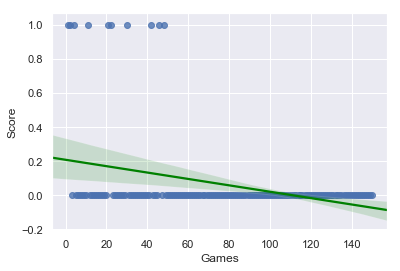

In [17]:

def run():
    pygame.init()
    agent = DQNAgent()
    counter_games = 0
    score_plot = []
    counter_plot =[]
    record = 0
    while counter_games < 150: 
        # Initialize classes
        game = Game(440, 440)
        player1 = game.player
        food1 = game.food

        # Perform first move
        initialize_game(player1, game, food1, agent)
        if display_option:
            display(player1, food1, game, record)

        while not game.crash:
            #agent.epsilon is set to give randomness to actions
            agent.epsilon = 80 - counter_games
            
            #get old state
            state_old = agent.get_state(game, player1, food1)
            
            #perform random actions based on agent.epsilon, or choose the action
            if randint(0, 200) < agent.epsilon:
                final_move = to_categorical(randint(0, 2), num_classes=3)
            else:
                # predict action based on the old state
                prediction = agent.model.predict(state_old.reshape((1,11)))
                final_move = to_categorical(np.argmax(prediction[0]), num_classes=3)
                
            #perform new move and get new state
            player1.do_move(final_move, player1.x, player1.y, game, food1, agent)
            state_new = agent.get_state(game, player1, food1)
            
            #set reward for the new state
            reward = agent.set_reward(player1, game.crash)
            
            #train short memory base on the new action and state
            agent.train_short_memory(state_old, final_move, reward, state_new, game.crash)
            
            # store the new data into a long term memory
            agent.remember(state_old, final_move, reward, state_new, game.crash)
            record = get_record(game.score, record)
            if display_option:
                display(player1, food1, game, record)
                pygame.time.wait(speed)
        
        agent.replay_new(agent.memory)
        counter_games += 1
        print('Game', counter_games, '      Score:', game.score)
        score_plot.append(game.score)
        counter_plot.append(counter_games)
    agent.model.save_weights('weights_3layers_05lr.hdf5')
    plot_seaborn(counter_plot, score_plot)


run()


3 layers / learning rate = .005

In [18]:


class DQNAgent(object):

    def __init__(self):
        self.reward = 0
        self.gamma = 0.9
        self.dataframe = pd.DataFrame()
        self.short_memory = np.array([])
        self.agent_target = 1
        self.agent_predict = 0
        self.learning_rate = 0.005
        self.model = self.network()
        self.epsilon = 0
        self.actual = []
        self.memory = []

    def get_state(self, game, player, food):

        state = [
            (player.x_change == 20 and player.y_change == 0 and ((list(map(add, player.position[-1], [20, 0])) in player.position) or
            player.position[-1][0] + 20 >= (game.game_width - 20))) or (player.x_change == -20 and player.y_change == 0 and ((list(map(add, player.position[-1], [-20, 0])) in player.position) or
            player.position[-1][0] - 20 < 20)) or (player.x_change == 0 and player.y_change == -20 and ((list(map(add, player.position[-1], [0, -20])) in player.position) or
            player.position[-1][-1] - 20 < 20)) or (player.x_change == 0 and player.y_change == 20 and ((list(map(add, player.position[-1], [0, 20])) in player.position) or
            player.position[-1][-1] + 20 >= (game.game_height-20))),  # danger straight

            (player.x_change == 0 and player.y_change == -20 and ((list(map(add,player.position[-1],[20, 0])) in player.position) or
            player.position[ -1][0] + 20 > (game.game_width-20))) or (player.x_change == 0 and player.y_change == 20 and ((list(map(add,player.position[-1],
            [-20,0])) in player.position) or player.position[-1][0] - 20 < 20)) or (player.x_change == -20 and player.y_change == 0 and ((list(map(
            add,player.position[-1],[0,-20])) in player.position) or player.position[-1][-1] - 20 < 20)) or (player.x_change == 20 and player.y_change == 0 and (
            (list(map(add,player.position[-1],[0,20])) in player.position) or player.position[-1][
             -1] + 20 >= (game.game_height-20))),  # danger right

             (player.x_change == 0 and player.y_change == 20 and ((list(map(add,player.position[-1],[20,0])) in player.position) or
             player.position[-1][0] + 20 > (game.game_width-20))) or (player.x_change == 0 and player.y_change == -20 and ((list(map(
             add, player.position[-1],[-20,0])) in player.position) or player.position[-1][0] - 20 < 20)) or (player.x_change == 20 and player.y_change == 0 and (
            (list(map(add,player.position[-1],[0,-20])) in player.position) or player.position[-1][-1] - 20 < 20)) or (
            player.x_change == -20 and player.y_change == 0 and ((list(map(add,player.position[-1],[0,20])) in player.position) or
            player.position[-1][-1] + 20 >= (game.game_height-20))), #danger left


            player.x_change == -20,  # move left
            player.x_change == 20,  # move right
            player.y_change == -20,  # move up
            player.y_change == 20,  # move down
            food.x_food < player.x,  # food left
            food.x_food > player.x,  # food right
            food.y_food < player.y,  # food up
            food.y_food > player.y  # food down
            ]

        for i in range(len(state)):
            if state[i]:
                state[i]=1
            else:
                state[i]=0

        return np.asarray(state)

    def set_reward(self, player, crash):
        self.reward = 0
        if crash:
            self.reward = -10
            return self.reward
        if player.eaten:
            self.reward = 10
        return self.reward

    def network(self, weights=None):
        model = Sequential()
        model.add(Dense(activation="relu", input_dim=11, units=120))
        model.add(Dropout(0.15))
        model.add(Dense(activation="relu", units=120))
        model.add(Dropout(0.15))
        model.add(Dense(activation="relu", units=120))
        model.add(Dropout(0.15))
        model.add(Dense(activation="softmax", units=3))
        adam = optimizers.Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        model.compile(loss='mse', optimizer= adam)
        
        if weights:
            model.load_weights(weights)
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay_new(self, memory):
        if len(memory) > 1000:
            minibatch = random.sample(memory, 1000)
        else:
            minibatch = memory
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(np.array([next_state]))[0])
            target_f = self.model.predict(np.array([state]))
            target_f[0][np.argmax(action)] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)

    def train_short_memory(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape((1, 11)))[0])
        target_f = self.model.predict(state.reshape((1, 11)))
        target_f[0][np.argmax(action)] = target
        self.model.fit(state.reshape((1, 11)), target_f, epochs=1, verbose=0)

Game 1       Score: 1
Game 2       Score: 1
Game 3       Score: 1
Game 4       Score: 0
Game 5       Score: 1
Game 6       Score: 0
Game 7       Score: 1
Game 8       Score: 2
Game 9       Score: 1
Game 10       Score: 3
Game 11       Score: 0
Game 12       Score: 0
Game 13       Score: 1
Game 14       Score: 0
Game 15       Score: 0
Game 16       Score: 2
Game 17       Score: 0
Game 18       Score: 0
Game 19       Score: 0
Game 20       Score: 0
Game 21       Score: 1
Game 22       Score: 0
Game 23       Score: 0
Game 24       Score: 0
Game 25       Score: 0
Game 26       Score: 1
Game 27       Score: 0
Game 28       Score: 0
Game 29       Score: 0
Game 30       Score: 0
Game 31       Score: 1
Game 32       Score: 0
Game 33       Score: 1
Game 34       Score: 1
Game 35       Score: 1
Game 36       Score: 0
Game 37       Score: 0
Game 38       Score: 1
Game 39       Score: 0
Game 40       Score: 0
Game 41       Score: 1
Game 42       Score: 2
Game 43       Score: 0
Game 44       Score:

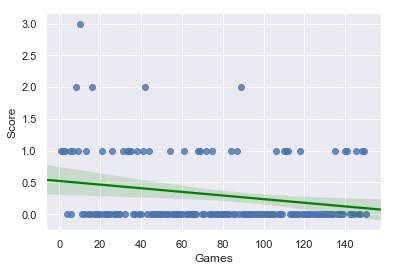

In [19]:

def run():
    pygame.init()
    agent = DQNAgent()
    counter_games = 0
    score_plot = []
    counter_plot =[]
    record = 0
    while counter_games < 150: 
        # Initialize classes
        game = Game(440, 440)
        player1 = game.player
        food1 = game.food

        # Perform first move
        initialize_game(player1, game, food1, agent)
        if display_option:
            display(player1, food1, game, record)

        while not game.crash:
            #agent.epsilon is set to give randomness to actions
            agent.epsilon = 80 - counter_games
            
            #get old state
            state_old = agent.get_state(game, player1, food1)
            
            #perform random actions based on agent.epsilon, or choose the action
            if randint(0, 200) < agent.epsilon:
                final_move = to_categorical(randint(0, 2), num_classes=3)
            else:
                # predict action based on the old state
                prediction = agent.model.predict(state_old.reshape((1,11)))
                final_move = to_categorical(np.argmax(prediction[0]), num_classes=3)
                
            #perform new move and get new state
            player1.do_move(final_move, player1.x, player1.y, game, food1, agent)
            state_new = agent.get_state(game, player1, food1)
            
            #set reward for the new state
            reward = agent.set_reward(player1, game.crash)
            
            #train short memory base on the new action and state
            agent.train_short_memory(state_old, final_move, reward, state_new, game.crash)
            
            # store the new data into a long term memory
            agent.remember(state_old, final_move, reward, state_new, game.crash)
            record = get_record(game.score, record)
            if display_option:
                display(player1, food1, game, record)
                pygame.time.wait(speed)
        
        agent.replay_new(agent.memory)
        counter_games += 1
        print('Game', counter_games, '      Score:', game.score)
        score_plot.append(game.score)
        counter_plot.append(counter_games)
    agent.model.save_weights('weights_3layers_005lr.hdf5')
    plot_seaborn(counter_plot, score_plot)


run()


3 layers / learning rate = .0005

In [14]:
class DQNAgent(object):

    def __init__(self):
        self.reward = 0
        self.gamma = 0.9
        self.dataframe = pd.DataFrame()
        self.short_memory = np.array([])
        self.agent_target = 1
        self.agent_predict = 0
        self.learning_rate = 0.0005
        self.model = self.network()
        self.epsilon = 0
        self.actual = []
        self.memory = []

    def get_state(self, game, player, food):

        state = [
            (player.x_change == 20 and player.y_change == 0 and ((list(map(add, player.position[-1], [20, 0])) in player.position) or
            player.position[-1][0] + 20 >= (game.game_width - 20))) or (player.x_change == -20 and player.y_change == 0 and ((list(map(add, player.position[-1], [-20, 0])) in player.position) or
            player.position[-1][0] - 20 < 20)) or (player.x_change == 0 and player.y_change == -20 and ((list(map(add, player.position[-1], [0, -20])) in player.position) or
            player.position[-1][-1] - 20 < 20)) or (player.x_change == 0 and player.y_change == 20 and ((list(map(add, player.position[-1], [0, 20])) in player.position) or
            player.position[-1][-1] + 20 >= (game.game_height-20))),  # danger straight

            (player.x_change == 0 and player.y_change == -20 and ((list(map(add,player.position[-1],[20, 0])) in player.position) or
            player.position[ -1][0] + 20 > (game.game_width-20))) or (player.x_change == 0 and player.y_change == 20 and ((list(map(add,player.position[-1],
            [-20,0])) in player.position) or player.position[-1][0] - 20 < 20)) or (player.x_change == -20 and player.y_change == 0 and ((list(map(
            add,player.position[-1],[0,-20])) in player.position) or player.position[-1][-1] - 20 < 20)) or (player.x_change == 20 and player.y_change == 0 and (
            (list(map(add,player.position[-1],[0,20])) in player.position) or player.position[-1][
             -1] + 20 >= (game.game_height-20))),  # danger right

             (player.x_change == 0 and player.y_change == 20 and ((list(map(add,player.position[-1],[20,0])) in player.position) or
             player.position[-1][0] + 20 > (game.game_width-20))) or (player.x_change == 0 and player.y_change == -20 and ((list(map(
             add, player.position[-1],[-20,0])) in player.position) or player.position[-1][0] - 20 < 20)) or (player.x_change == 20 and player.y_change == 0 and (
            (list(map(add,player.position[-1],[0,-20])) in player.position) or player.position[-1][-1] - 20 < 20)) or (
            player.x_change == -20 and player.y_change == 0 and ((list(map(add,player.position[-1],[0,20])) in player.position) or
            player.position[-1][-1] + 20 >= (game.game_height-20))), #danger left


            player.x_change == -20,  # move left
            player.x_change == 20,  # move right
            player.y_change == -20,  # move up
            player.y_change == 20,  # move down
            food.x_food < player.x,  # food left
            food.x_food > player.x,  # food right
            food.y_food < player.y,  # food up
            food.y_food > player.y  # food down
            ]

        for i in range(len(state)):
            if state[i]:
                state[i]=1
            else:
                state[i]=0

        return np.asarray(state)

    def set_reward(self, player, crash):
        self.reward = 0
        if crash:
            self.reward = -10
            return self.reward
        if player.eaten:
            self.reward = 10
        return self.reward

    def network(self, weights=None):
        model = Sequential()
        model.add(Dense(activation="relu", input_dim=11, units=120))
        model.add(Dropout(0.15))
        model.add(Dense(activation="relu", units=120))
        model.add(Dropout(0.15))
        model.add(Dense(activation="relu", units=120))
        model.add(Dropout(0.15))
        model.add(Dense(activation="softmax", units=3))
        adam = optimizers.Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        model.compile(loss='mse', optimizer= adam)
        
        if weights:
            model.load_weights(weights)
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay_new(self, memory):
        if len(memory) > 1000:
            minibatch = random.sample(memory, 1000)
        else:
            minibatch = memory
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(np.array([next_state]))[0])
            target_f = self.model.predict(np.array([state]))
            target_f[0][np.argmax(action)] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)

    def train_short_memory(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape((1, 11)))[0])
        target_f = self.model.predict(state.reshape((1, 11)))
        target_f[0][np.argmax(action)] = target
        self.model.fit(state.reshape((1, 11)), target_f, epochs=1, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Game 1       Score: 0
Game 2       Score: 1
Game 3       Score: 0
Game 4       Score: 0
Game 5       Score: 0
Game 6       Score: 0
Game 7       Score: 0
Game 8       Score: 0
Game 9       Score: 0
Game 10       Score: 0
Game 11       Score: 0
Game 12       Score: 0
Game 13       Score: 0
Game 14       Score: 0
Game 15       Score: 0
Game 16       Score: 1
Game 17       Score: 0
Game 18       Score: 1
Game 19       Score: 0
Game 20       Score: 0
Game 21       Score: 1
Game 22       Score: 1
Game 23       Score: 1
Game 24       Score: 2
Game 25       Score: 1
Game 26       Score: 0
Game 27       Score: 1
Game 28       Score: 0
Game 29       Score: 1
Game 30       Score: 0
Game 31       Score: 1
Game 32       Score: 1
Game 33       Score: 1
Game 34       S

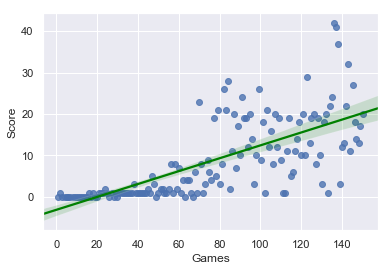

In [15]:

def run():
    pygame.init()
    agent = DQNAgent()
    counter_games = 0
    score_plot = []
    counter_plot =[]
    record = 0
    while counter_games < 150:  
        # Initialize classes
        game = Game(440, 440)
        player1 = game.player
        food1 = game.food

        # Perform first move
        initialize_game(player1, game, food1, agent)
        if display_option:
            display(player1, food1, game, record)

        while not game.crash:
            #agent.epsilon is set to give randomness to actions
            agent.epsilon = 80 - counter_games
            
            #get old state
            state_old = agent.get_state(game, player1, food1)
            
            #perform random actions based on agent.epsilon, or choose the action
            if randint(0, 200) < agent.epsilon:
                final_move = to_categorical(randint(0, 2), num_classes=3)
            else:
                # predict action based on the old state
                prediction = agent.model.predict(state_old.reshape((1,11)))
                final_move = to_categorical(np.argmax(prediction[0]), num_classes=3)
                
            #perform new move and get new state
            player1.do_move(final_move, player1.x, player1.y, game, food1, agent)
            state_new = agent.get_state(game, player1, food1)
            
            #set reward for the new state
            reward = agent.set_reward(player1, game.crash)
            
            #train short memory base on the new action and state
            agent.train_short_memory(state_old, final_move, reward, state_new, game.crash)
            
            # store the new data into a long term memory
            agent.remember(state_old, final_move, reward, state_new, game.crash)
            record = get_record(game.score, record)
            if display_option:
                display(player1, food1, game, record)
                pygame.time.wait(speed)
        
        agent.replay_new(agent.memory)
        counter_games += 1
        print('Game', counter_games, '      Score:', game.score)
        score_plot.append(game.score)
        counter_plot.append(counter_games)
    agent.model.save_weights('weights_3layer_0005lr.hdf5')
    plot_seaborn(counter_plot, score_plot)


run()


3 layers / learning rate = .00005

In [20]:


class DQNAgent(object):

    def __init__(self):
        self.reward = 0
        self.gamma = 0.9
        self.dataframe = pd.DataFrame()
        self.short_memory = np.array([])
        self.agent_target = 1
        self.agent_predict = 0
        self.learning_rate = 0.00005
        self.model = self.network()
        self.epsilon = 0
        self.actual = []
        self.memory = []

    def get_state(self, game, player, food):

        state = [
            (player.x_change == 20 and player.y_change == 0 and ((list(map(add, player.position[-1], [20, 0])) in player.position) or
            player.position[-1][0] + 20 >= (game.game_width - 20))) or (player.x_change == -20 and player.y_change == 0 and ((list(map(add, player.position[-1], [-20, 0])) in player.position) or
            player.position[-1][0] - 20 < 20)) or (player.x_change == 0 and player.y_change == -20 and ((list(map(add, player.position[-1], [0, -20])) in player.position) or
            player.position[-1][-1] - 20 < 20)) or (player.x_change == 0 and player.y_change == 20 and ((list(map(add, player.position[-1], [0, 20])) in player.position) or
            player.position[-1][-1] + 20 >= (game.game_height-20))),  # danger straight

            (player.x_change == 0 and player.y_change == -20 and ((list(map(add,player.position[-1],[20, 0])) in player.position) or
            player.position[ -1][0] + 20 > (game.game_width-20))) or (player.x_change == 0 and player.y_change == 20 and ((list(map(add,player.position[-1],
            [-20,0])) in player.position) or player.position[-1][0] - 20 < 20)) or (player.x_change == -20 and player.y_change == 0 and ((list(map(
            add,player.position[-1],[0,-20])) in player.position) or player.position[-1][-1] - 20 < 20)) or (player.x_change == 20 and player.y_change == 0 and (
            (list(map(add,player.position[-1],[0,20])) in player.position) or player.position[-1][
             -1] + 20 >= (game.game_height-20))),  # danger right

             (player.x_change == 0 and player.y_change == 20 and ((list(map(add,player.position[-1],[20,0])) in player.position) or
             player.position[-1][0] + 20 > (game.game_width-20))) or (player.x_change == 0 and player.y_change == -20 and ((list(map(
             add, player.position[-1],[-20,0])) in player.position) or player.position[-1][0] - 20 < 20)) or (player.x_change == 20 and player.y_change == 0 and (
            (list(map(add,player.position[-1],[0,-20])) in player.position) or player.position[-1][-1] - 20 < 20)) or (
            player.x_change == -20 and player.y_change == 0 and ((list(map(add,player.position[-1],[0,20])) in player.position) or
            player.position[-1][-1] + 20 >= (game.game_height-20))), #danger left


            player.x_change == -20,  # move left
            player.x_change == 20,  # move right
            player.y_change == -20,  # move up
            player.y_change == 20,  # move down
            food.x_food < player.x,  # food left
            food.x_food > player.x,  # food right
            food.y_food < player.y,  # food up
            food.y_food > player.y  # food down
            ]

        for i in range(len(state)):
            if state[i]:
                state[i]=1
            else:
                state[i]=0

        return np.asarray(state)

    def set_reward(self, player, crash):
        self.reward = 0
        if crash:
            self.reward = -10
            return self.reward
        if player.eaten:
            self.reward = 10
        return self.reward

    def network(self, weights=None):
        model = Sequential()
        model.add(Dense(activation="relu", input_dim=11, units=120))
        model.add(Dropout(0.15))
        model.add(Dense(activation="relu", units=120))
        model.add(Dropout(0.15))
        model.add(Dense(activation="relu", units=120))
        model.add(Dropout(0.15))
        model.add(Dense(activation="softmax", units=3))
        adam = optimizers.Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        model.compile(loss='mse', optimizer= adam)
        
        if weights:
            model.load_weights(weights)
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay_new(self, memory):
        if len(memory) > 1000:
            minibatch = random.sample(memory, 1000)
        else:
            minibatch = memory
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(np.array([next_state]))[0])
            target_f = self.model.predict(np.array([state]))
            target_f[0][np.argmax(action)] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)

    def train_short_memory(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape((1, 11)))[0])
        target_f = self.model.predict(state.reshape((1, 11)))
        target_f[0][np.argmax(action)] = target
        self.model.fit(state.reshape((1, 11)), target_f, epochs=1, verbose=0)

Game 1       Score: 0
Game 2       Score: 0
Game 3       Score: 0
Game 4       Score: 1
Game 5       Score: 1
Game 6       Score: 1
Game 7       Score: 0
Game 8       Score: 1
Game 9       Score: 0
Game 10       Score: 1
Game 11       Score: 1
Game 12       Score: 4
Game 13       Score: 1
Game 14       Score: 3
Game 15       Score: 1
Game 16       Score: 1
Game 17       Score: 2
Game 18       Score: 0
Game 19       Score: 1
Game 20       Score: 1
Game 21       Score: 1
Game 22       Score: 2
Game 23       Score: 2
Game 24       Score: 1
Game 25       Score: 2
Game 26       Score: 3
Game 27       Score: 2
Game 28       Score: 1
Game 29       Score: 3
Game 30       Score: 3
Game 31       Score: 3
Game 32       Score: 3
Game 33       Score: 2
Game 34       Score: 5
Game 35       Score: 3
Game 36       Score: 3
Game 37       Score: 4
Game 38       Score: 3
Game 39       Score: 1
Game 40       Score: 5
Game 41       Score: 5
Game 42       Score: 2
Game 43       Score: 4
Game 44       Score:

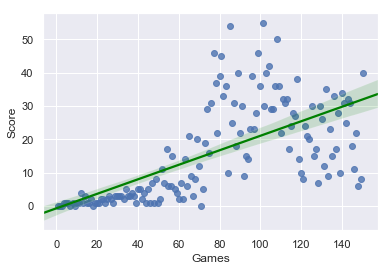

In [21]:

def run():
    pygame.init()
    agent = DQNAgent()
    counter_games = 0
    score_plot = []
    counter_plot =[]
    record = 0
    while counter_games < 150: 
        # Initialize classes
        game = Game(440, 440)
        player1 = game.player
        food1 = game.food

        # Perform first move
        initialize_game(player1, game, food1, agent)
        if display_option:
            display(player1, food1, game, record)

        while not game.crash:
            #agent.epsilon is set to give randomness to actions
            agent.epsilon = 80 - counter_games
            
            #get old state
            state_old = agent.get_state(game, player1, food1)
            
            #perform random actions based on agent.epsilon, or choose the action
            if randint(0, 200) < agent.epsilon:
                final_move = to_categorical(randint(0, 2), num_classes=3)
            else:
                # predict action based on the old state
                prediction = agent.model.predict(state_old.reshape((1,11)))
                final_move = to_categorical(np.argmax(prediction[0]), num_classes=3)
                
            #perform new move and get new state
            player1.do_move(final_move, player1.x, player1.y, game, food1, agent)
            state_new = agent.get_state(game, player1, food1)
            
            #set reward for the new state
            reward = agent.set_reward(player1, game.crash)
            
            #train short memory base on the new action and state
            agent.train_short_memory(state_old, final_move, reward, state_new, game.crash)
            
            # store the new data into a long term memory
            agent.remember(state_old, final_move, reward, state_new, game.crash)
            record = get_record(game.score, record)
            if display_option:
                display(player1, food1, game, record)
                pygame.time.wait(speed)
        
        agent.replay_new(agent.memory)
        counter_games += 1
        print('Game', counter_games, '      Score:', game.score)
        score_plot.append(game.score)
        counter_plot.append(counter_games)
    agent.model.save_weights('weights_3layers_00005lr.hdf5')
    plot_seaborn(counter_plot, score_plot)


run()
